# Masterthesis

---

## Description

| Name | Version | Build | Channel |
| -------------------- | ------- | ------------------ | ----------- |
| hdbscan | 0.8.26 | py38h0b5ebd8_3 | conda-forge |
| jedi | 0.17.2 | py38h578d9bd_1 | conda-forge |
| jupyter-resource-usage | 0.5.1 | pyhd8ed1ab_0 | conda-forge |
| jupyterlab | 3.0.5 | pyhd8ed1ab_0 | conda-forge |
| nodejs | 15.3.0 | h25f6087_0 | conda-forge |
| pandas | 1.2.1 | py38h51da96c_0 | conda-forge |
| progressbar2 | 3.53.1 | pyh9f0ad1d_0 | conda-forge |
| umap-learn | 0.4.6 | py38h32f6830_0 | conda-forge |
| seaborn | | | |
| biopython | | | |
| mafft | | | | 

- Alexander Henoch
- conda install jedi=0.17.2 jupyterlab jupyter-resource-usage nodejs umap-learn=0.4.6 hdbscan=0.8.26 pandas progressbar2 seaborn joblib=0.17.0 biopython mafft
- jupyter labextension install @jupyterlab/fasta-extension

---

## To-Do

1. [X] Frequency extraction 
2. [ ] Clustering UMAP/HDB
    1. [X] Parameter exploration
    2. [X] Cluster number reduction
    3. [ ] Centroid extraction
    4. [ ] New Subtype Classification
3. [X] Subtype interaction matrix
    1. [X] Iteraction counting
4. [ ] Alignment
    1. [X] Mafft inclusion
    2. 
5. [ ] Circle hunt
6. [ ] Mutations
7. [ ] Write Thesis

---

## Introduction

1. Virus/Pandemia
2. Influenza/Danger
3. Segments/Subtypes
4. Sequencing/NTs/AAs/Mutations
5. Clustering/-methods/Hierarchical/HDB
6. K-mer Frequencies/Dimensions/UMAP
7. Linkage Trees/define k/Parameter
8. ...
9. biol. Subtypes/new Subtypes?
10. Alignments/Structures
11. Thesis

---

## Methods

1. 
2. UMAP/HDB/hybrid clustering
3. Metrices/Scorings/DBCV/Epsilon/treecutting
4. 

---

## Results and Discussion

1. 
2. DBCV/Epsilon (Plot)
3. cluster density (Plot)
4. cluster + linkage tree(?)
5. subtypes?
6. 

---

### Package import

- numpy, pandas: Dataframes
- sys, re, csv, time: Python core functions
- collections, itertools: Extended core functions
- umap, hdbscan: Clustering
- plotnine, matplotlib inline: Plotting 

---

In [94]:
import numpy as np
import pandas as pd
import sys
import os
import re
import csv
import collections as co
import itertools as it
import umap
import hdbscan
import time 
import progressbar

from Bio.Align.Applications import MafftCommandline
from matplotlib import colors 
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.transforms as transforms
import scipy.spatial.distance as ssd

%matplotlib inline

### Clustering

#### K-mer Frequency calculation

- my frequency class
    - max possible RAM save
    - creation of matrix beforehand (adjustment)
        - runtime + / RAM -
    - no concatenation /copy of data -> more RAM)
        - filling existing matrix
        - has to be in the exact right size!
    - Ns frequency
        - ...
    - AAs with Ns
        - ...
    
---

In [2]:
class frequency(object):
    
    def __init__(self, k = 7, convert = 0):
    
        self.k = k
        self.convert = convert
        self.exist = co.defaultdict(int) 
        self.keys = list(self.exist.keys())
        self.col = len(self.keys)
        self.row = 0
        self.matrix = np.empty((self.row, self.col, ),dtype = "float32")
        self.amino = co.defaultdict(str, {
            'AAA':'K', 'AAC':'N', 'AAG':'K', 'AAT':'N',
            'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AGA':'R', 'AGC':'S', 'AGG':'R', 'AGT':'S',
            'ATA':'I', 'ATC':'I', 'ATG':'M', 'ATT':'I',
            'CAA':'Q', 'CAC':'H', 'CAG':'Q', 'CAT':'H',
            'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
            'GAA':'E', 'GAC':'D', 'GAG':'E', 'GAT':'D',
            'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',    
            'TAA':'Y', 'TAC':'*', 'TAG':'*', 'TAT':'Y',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
            'TGA':'*', 'TGC':'C', 'TGG':'W', 'TGT':'C',
            'TTA':'L', 'TTC':'F', 'TTG':'L', 'TTT':'F'
        })
                
    def translate(self, read):
    
        chain = ''

        for i in range(len(read) - 2):
            trip = read[i:i+3]
            chain += self.amino[trip]

        return(chain)
    
    
    def adjust_to_data(self, infile):
    
        self.row = infile.shape[0]
            
        for line, read in infile.itertuples(index=True, name=None):

            if self.convert == 1:
                seq = self.translate(read)
                del read

                num = len(seq) - self.k + 1

                for i in range(num):
                    kmer = seq[i:i+self.k]
                    self.exist[kmer] = 0

            else:
                seq = read
                del read

                num = len(seq) - self.k + 1

                if re.match('^[ACGT]*$', seq): 
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        self.exist[kmer] = 0
                else:
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        if re.match('^[ACGT]*$', kmer): 
                            self.exist[kmer] = 0
            
        self.keys = list(self.exist.keys())
        self.col = len(self.keys)
        self.matrix = np.empty((self.row, self.col, ), dtype="float32")
        
        del seq
    
    
    def calculate_frequence(self, infile):
        
        for line, read in infile.itertuples(index=True, name=None): 
                 
            if self.convert == 1:
                seq = self.translate(read)
                del read

                counts = self.exist.copy()
                num = len(seq) - self.k + 1

                for i in range(num):
                    kmer = seq[i:i+self.k]
                    counts[kmer] += 1

            else:
                seq = read
                del read

                counts = self.exist.copy()
                num = len(seq) - self.k + 1

                if re.match('^[ACGT]*$', seq): 
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        counts[kmer] += 1
                else:
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        if re.match('^[ACGT]*$', kmer): 
                            counts[kmer] += 1

            vector = np.array(list(counts.values()), dtype = "float32")/num

            self.matrix[line] = vector
            
            counts.clear()
            del vector
            del seq
            del counts
    
    
    def get_keys(self):
        
        return(self.keys)
    
    
    def get_matrix(self):
        
        return(self.matrix)

#### Frequency Vector Dimension reduction

- n neighbors:
    - difficult
    - below 50 = ~400 **very good** clusters
    - around 100 = ~250 **good** clusters
    - above 200 = ~150 **mediocre** clusters
- min. dist:
    - less as possible for better seperation in dimension reduction
    - 0.1 creates more noise than 0.0
- n components:
    - the higher the resulting dimension the more time is needed for HDB clustering
- random state:
    - 42 answer on everything in the universe
    - completely **useless** parameter
- metric:
    - seems to have very little effect on the **euclidean** clustering of HDB
- frequency:
    - removed frequency of AA chain
    - *way better results*
    
---

In [3]:
def convert_fasta(infile, outfile):

    #with some help from https://stackoverflow.com/questions/50856538/how-to-convert-multiline-fasta-files-to-singleline-fasta-files-without-biopython
    
    with open(infile) as f_input, open(outfile, 'w') as f_output:

        block = []

        for line in f_input:

            if line.startswith('>'):

                if block:
                    f_output.write(new_line + ',' + "".join(block) + '\n')
                    block = []
                
                new_line = line.strip().replace('|', ',')
            else:
                block.append(line.strip())

        if block:
            f_output.write(new_line + ',' + "".join(block) + '\n')

#### Convert Fasta to CSV

---

In [4]:
def get_vectors(sequence, accession):

    freq = frequency(k = 7, convert = 0)
    freq.adjust_to_data(sequence)
    freq.calculate_frequence(sequence)

    matrix = freq.get_matrix()
    keys = freq.get_keys()

    #Dimension Reduction with UMAP

    reduced = umap.UMAP(
        n_neighbors = 100,
        min_dist = 0.0,
        n_components = 20,
        random_state = 42,
        metric = 'cosine',
    ).fit_transform(matrix)

    dataframe = pd.concat([accession, pd.DataFrame(reduced)], axis=1, copy = False, ignore_index = False).set_index('accession')
    
    return(dataframe)

#### DBCV and Epsilon Cutoff Discovery

- **HDB scan don't necessarily create round clusters**
    - calculations based on round clusters are useless
    - centroid calculation difficult
    - inner cluster distances wrong
    - silhouette score wrong
        - look [here](https://pberba.github.io/stats/2020/01/17/hdbscan/)
- DBCV and Epsilon
    - Epsilon:
        - Hybrid clustering with DBSCAN* and HDBSCAN*
        - look [here](https://hdbscan.readthedocs.io/en/latest/how_to_use_epsilon.html)
    - DBCV:
        - Density Based Cluster Validity (DBCV) score
        - [paper](https://www.dbs.ifi.lmu.de/~zimek/publications/SDM2014/DBCV.pdf)
        - needs minimum spanning tree (parameter = True)
    - loop to increse Epsilon by comparison with the DBCV score
    - *seems to be promising*
- centroids:
    - *maybe by extraction exemplars and connect them single linkage wise*
    - *~13000 exemplars and 13000 clusters -> 250 clusters*
    - *how to shrink number of exemplars*
- removed reinitialisation of lists to save all values
- unclustered and cluster number removed and integrated in final clustering

---

In [5]:
def get_epsilon(dataframe):
    
    epsilon = 0.0
    dbcv_list = []
    #n_cluster_list = []
    #unclustered_list = []
    epsilon_list = []

    clusterer_init = hdbscan.HDBSCAN(
        min_samples = 1,
        min_cluster_size = 2,
        cluster_selection_epsilon = 0.0,
        gen_min_span_tree=True,
        #metric = 'euclidean',
    ).fit(dataframe)

    epsilon_max = clusterer_init.single_linkage_tree_.to_pandas()['distance'].max().item()

    while epsilon <= epsilon_max:

        clusterer = hdbscan.HDBSCAN(
            min_samples = 1,
            min_cluster_size = 2,
            cluster_selection_epsilon = epsilon,
            gen_min_span_tree=True,
            #metric = 'euclidean',
        ).fit(dataframe)

        dbcv_list.append(clusterer.relative_validity_.item())
        label = list(clusterer.labels_)
        #n_cluster_list.append(len(set(label))-1)
        #unclustered_list.append(label.count(-1))
        epsilon_list.append(epsilon)

        epsilon = round(epsilon + 1.0, 2)

    epsilon_best = epsilon_list[dbcv_list.index(max(dbcv_list))]

    #print(f"First rough iteration:")
    #print(f"Best DBCV value: {max(dbcv_list)}")
    #print(f"Cluster number: {n_cluster_list[dbcv_list.index(max(dbcv_list))]}")
    #print(f"Unclustered/Noise: {unclustered_list[dbcv_list.index(max(dbcv_list))]}")

    epsilon = round(epsilon_best - 1.0, 2)

    if (epsilon < 0.0):
        epsilon = 0.0

    epsilon_max = round(epsilon_best + 1.0, 2)
    #dbcv_list = []
    #n_cluster_list = []
    #unclustered_list = []
    #epsilon_list = []

    #DBCV Exploration (fine)

    while epsilon <= epsilon_max:

        clusterer = hdbscan.HDBSCAN(
            min_samples = 1,
            min_cluster_size = 2,
            cluster_selection_epsilon = epsilon,
            gen_min_span_tree=True,
            #metric = 'euclidean',
        ).fit(dataframe)

        dbcv_list.append(clusterer.relative_validity_.item())
        label = list(clusterer.labels_)
        #n_cluster_list.append(len(set(label))-1)
        #unclustered_list.append(label.count(-1))
        epsilon_list.append(epsilon)

        epsilon = round(epsilon + 0.1, 2)

    dbcv_best = max(dbcv_list)
    epsilon_best = epsilon_list[dbcv_list.index(dbcv_best)]
    parameter = pd.DataFrame(zip(epsilon_list, dbcv_list), columns = ['epsilon', 'DBCV']).set_index('epsilon')
    
    #print(f"Second fine iteration:")
    #print(f"Best DBCV value: {max(dbcv_list)}")
    #print(f"Cluster number: {n_cluster_list[dbcv_list.index(max(dbcv_list))]}")
    #print(f"Unclustered/Noise: {unclustered_list[dbcv_list.index(max(dbcv_list))]}")
    
    return(parameter, epsilon_best, dbcv_best)

#### Clustering using optimized Epsilon

- Final clustering
    - *is the clustering the best possible?*
    - min. samples: the higher the more conservative = more noise = more unclustered
    - min. clustersize: value small? some very special influenza strains should be in small clusters
        - *maybe increase*
    - selection method?
        - HDB hybrid pager is a comparison and eom seems to be more matching

---

In [6]:
def get_cluster(epsilon_best, dataframe, extra, accession):

    clusterer_best = hdbscan.HDBSCAN(
        min_samples = 1,
        min_cluster_size = 2,
        cluster_selection_epsilon = epsilon_best,
        gen_min_span_tree=True,
        cluster_selection_method = 'eom',
        #metric = 'euclidean',
    ).fit(dataframe)

    label = clusterer_best.labels_
    label_list = label.tolist()
    
    n_cluster = len(set(label_list))-1
    unclustered = label_list.count(-1)
    
    cluster = pd.concat([pd.DataFrame(label, columns = ['cluster']), extra, accession], axis=1, copy = False).set_index('accession')
    linkage = clusterer_best.single_linkage_tree_.to_pandas()
    linkage.set_index('parent', inplace = True)
    
    #N_unmatch = cluster.groupby('cluster').filter(lambda x: x['N'].nunique() > 1).cluster.nunique()
    N_unmatch = cluster.groupby('cluster').filter(lambda x: x['N'].replace('', np.nan).nunique() > 1).cluster.nunique()
    H_unmatch = cluster.groupby('cluster').filter(lambda x: x['H'].replace('', np.nan).nunique() > 1).cluster.nunique() 
    
    return(cluster, linkage, n_cluster, unclustered, H_unmatch, N_unmatch)

#### Centroid extraction

In [7]:
def get_centroids(cluster, dataframe):
    
    centroid = cluster[['cluster']].copy()
    centroid.insert(1, 'centroid', 'false')

    num = cluster['cluster'].max()+1
    values = ['true']*num
    accessions = []

    for i in range(num):

        query = cluster[cluster.cluster == i]
        match = query.index.values.tolist()
        sub = dataframe.filter(items = match, axis=0)
        dist = ssd.cdist(sub, sub, metric = 'cosine')
        inner_mean = pd.DataFrame(dist, columns = match, index = match, dtype = 'float32').mean()
        accessions.append(inner_mean.idxmin())

    centroid.update(pd.DataFrame(values, columns=['centroid'], index = accessions))

    return(centroid)

#### Finding th Elbow Method parameter for Backup

---

In [8]:
def get_elbow(linkage):
    
    #with some help from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    
    Z = linkage.reset_index().drop(columns=['parent']).to_numpy()

    last = Z[-400:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)

    acceleration = np.diff(last, 2)  # 2nd derivative of the distances
    acceleration_rev = acceleration[::-1]
    
    elbow = pd.DataFrame({'n_cluster': idxs[1:-1], 'distance': last_rev[1:-1], 'acceleration': acceleration_rev}).set_index('n_cluster')
    
    return(elbow)

#### Plot Parameter

---

In [9]:
def plot_dbcv(parameter):

    sns.set()
    graph = sns.FacetGrid(parameter, col ='segment', col_wrap=4, sharex=True, sharey=True, height=4)
    graph.map(sns.lineplot, "epsilon", "DBCV")#.add_legend() 
    graph.map_dataframe(annotate_dbcv)
    graph.set_axis_labels("Epsilon", "DBCV")
    graph.set_titles(col_template="Segment {col_name}", row_template="Segment {row_name}")
    #plt.subplots_adjust(top=0.9)
    #graph.fig.suptitle('DBCV by changing Epsilon')
    
    plt.tight_layout()
    plt.savefig('DBCV_Epsilon.svg')
    plt.savefig('DBCV_Epsilon.pdf')
    plt.show() 

In [10]:
def annotate_dbcv(data, **kws):
    
    x = data["epsilon"][data["DBCV"].idxmax()].item()
    #t = str(n)
    ax = plt.gca()
    
    trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)
    
    ax.axvline(x = x, alpha=.5, color="r")
    ax.text(x, 0.05, f"{x:0.1f}", rotation='vertical', ha='right', transform=trans, color = "r", alpha=.5)

#### Plot Density

---

In [11]:
def plot_density(density):

    sns.set()
    
    histo = sns.FacetGrid(density, col ='segment', col_wrap=4, sharex=True, sharey=True, height=4) 
    histo.map(sns.histplot, "size", kde=True, log_scale=True, binwidth=0.1, element="step", fill = True)#.add_legend()
    histo.map_dataframe(annotate_density)
    histo.set_axis_labels("Count", "Cluster Size")
    histo.set_titles(col_template="Segment {col_name}", row_template="Segment {row_name}")
    #plt.subplots_adjust(top=0.9)
    #histo.fig.suptitle('Cluster Size Distribution')

    plt.tight_layout()
    plt.savefig('Cluster_Distribution.svg')
    plt.savefig('Cluster_Distribution.pdf')
    plt.show()

In [12]:
def annotate_density(data, **kws):
    
    ax = plt.gca()
    
    dens_list = ax.get_lines()[0].get_data()[1]
    
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    
    max_dens_index = dens_list.argmax()

    x = ax.get_lines()[0].get_data()[0][max_dens_index]
    
    ax.axvline(x = x, alpha=.5, color="r")
    ax.text(x, 0.05, f"{x:0.1f}", rotation='vertical', ha='right', transform=trans, color = "r", alpha = 0.5)

#### Plot Elbow

---

In [13]:
def plot_elbow(elbow):

    sns.set()
    graph = sns.FacetGrid(elbow, col ='segment', col_wrap=4, sharex=True, sharey=True, height=4)
    graph.map(sns.lineplot, "n_cluster", "distance")#.add_legend() 
    graph.map(sns.lineplot, "n_cluster", "acceleration", color="r", alpha = 0.5)#.add_legend() 
    graph.set_axis_labels("Cluster [k]", "Distance")
    graph.set_titles(col_template="Segment {col_name}", row_template="Segment {row_name}")
    #plt.subplots_adjust(top=0.9)
    #graph.fig.suptitle('Clusternumber estimation by Elbow Method')

    plt.tight_layout()
    plt.savefig('Cluster_Elbow.svg')
    plt.savefig('Cluster_Elbow.pdf')
    plt.show() 

#### Plot Linkage tree

---

In [14]:
def plot_linkage(cluster, linkage, segment, protein):

#with some help from https://stackoverflow.com/questions/38153829/custom-cluster-colors-of-scipy-dendrogram-in-python-link-color-func
    
    num = cluster.query('segment == @segment')['cluster'].max().item()+1

    tree_hex = []
    if protein == 'H':
        tree_col = sns.color_palette('husl', n_colors=18)
    elif protein == 'N':
        tree_col = sns.color_palette('husl', n_colors=11)
    
    for col in tree_col:
        tree_hex.append(colors.to_hex(col))

    tree_cluster = cluster.query('segment == @segment')[protein]

    tree_label = tree_cluster.index

    mixed_hex = "#000000"
    tree_dict = {}
    
    for index, value in tree_cluster.items():
        
        if re.match(f'^[{protein}][0-9]+$', value): 
            tree_dict[index] = tree_hex[int(value[1:])]
        else:
            tree_dict[index] = mixed_hex

    tree_Z = linkage.query('segment == @segment').drop(columns=['segment', 'parent'])

    tree_np = tree_Z.to_numpy()

    dflt_hex = "#808080"
    tree_link = {}

    for i, i12 in enumerate(tree_np[:,:2].astype(int)):

        c1, c2 = (tree_link[x] if x > len(tree_np) else tree_dict[tree_label[x]] for x in i12)

        #tree_link[i+1+len(tree_np)] = c1 if c1 == c2 else dflt_hex

        if c1 == c2:
            tree_link[i+1+len(tree_np)] = c1 
        elif c1 == mixed_hex:
            tree_link[i+1+len(tree_np)] = c2
        elif c2 == mixed_hex:
            tree_link[i+1+len(tree_np)] = c1
        else: 
            tree_link[i+1+len(tree_np)] = dflt_hex


    plt.figure(figsize=(50, 100)) 
    sns.set()
    #plt.title('Hierarchical Clustering Dendrogram of Segment ' + str(segment) + ' colored by ' + str(protein) + ' Protein', fontsize=40)
    plt.ylabel('Sample Index', fontsize=30)
    plt.xlabel('Distance', fontsize=30)
    plt.xticks(fontsize = 20)
    plt.style.use('ggplot')
    with plt.rc_context({'lines.linewidth': 4}):
        dendrogram(Z=tree_np, labels=tree_label, color_threshold=None, leaf_font_size=15, leaf_rotation=0, link_color_func=lambda x: tree_link[x], truncate_mode='lastp', p=num, orientation="left")#, show_contracted=True)
    
    plt.tight_layout()
    plt.savefig('Linkage_Cluster_' + str(segment) + '.svg')
    plt.savefig('Linkage_Cluster_' + str(segment) + '.pdf')
    plt.show()

#### Main Pipeline

- Metric for centroids (cos)

In [15]:
def subsplit(subtype):
    if re.match('^[H][0-9]+N[0-9]+$', subtype): 
        H = re.search('[H][0-9]+', subtype).group(0)
        N = re.search('[N][0-9]+', subtype).group(0)
    else:
        H = ''#np.nan
        N = ''#np.nan
    return(H, N)

In [16]:
try:
    
    cluster = pd.read_csv('cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    centroid = pd.read_csv('centroid.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    genome = pd.read_csv('genome.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    linkage = pd.read_csv('linkage.csv', sep = ',', na_filter = False, header = 0)
    parameter = pd.read_csv('parameter.csv', sep = ',', na_filter = False, header = 0)
    information = pd.read_csv('information.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    density = pd.read_csv('density.csv', sep = ',', na_filter = False, header = 0)
    elbow = pd.read_csv('elbow.csv', sep = ',', na_filter = False, header = 0)

except:
    
    #Convert the Fasta to Csv
    convert_fasta('../Data/A.fasta', '../Data/A2.csv')
    
    #Dict Creation
    parameter_dict = co.defaultdict(list)
    cluster_dict = co.defaultdict(list)
    centroid_dict = co.defaultdict(list)
    information_dict = co.defaultdict(list)
    linkage_dict = co.defaultdict(list)
    elbow_dict = co.defaultdict(list)

    #Upload Fasta
    upload = pd.read_csv('../Data/A2.csv', sep = ',', na_filter = False, header = None)
    upload.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation', 'genome']
    upload.query('curation == "Pass"', inplace = True)
    upload[['H', 'N']] = upload.subtype.apply(lambda x: subsplit(x)).tolist()

    genome = upload[['accession', 'genome']].copy()
    genome.set_index('accession')
    
    #Progress Variables
    segments = [1, 2, 3, 4, 5, 6, 7, 8]
    widgets = [' [', progressbar.Timer(format = 'elapsed time: %(elapsed)s'), '] ', progressbar.Bar('#'),' (', progressbar.ETA(), ') ', ] 
    bar = progressbar.ProgressBar(max_value = len(segments), widgets = widgets).start() 

    #Pipeline
    #for segment in segments[:1]:
    for segment in segments:

        subset = upload.query('segment == @segment').reset_index()
        sequence = subset[['genome']].copy()
        accession = subset[['accession']].copy()
        extra = subset[['H', 'N', 'strain']].copy()

        dataframe = get_vectors(sequence, accession)
        parameter_dict[segment], epsilon_best, dbcv_best = get_epsilon(dataframe)
        cluster_dict[segment], linkage_dict[segment], n_cluster, unclustered, H_unmatch, N_unmatch = get_cluster(epsilon_best, dataframe, extra, accession)
        centroid_dict[segment] = get_centroids(cluster_dict[segment], dataframe)
        information_dict[segment] = [n_cluster, unclustered, H_unmatch, N_unmatch, epsilon_best, dbcv_best]
        elbow_dict[segment] = get_elbow(linkage_dict[segment])

        bar.update(segment)

    bar.finish()    

    #Polish the Tables
    cluster = pd.concat(cluster_dict)
    cluster.index.set_names(["segment", "accession"], inplace=True)
    cluster.reset_index(level = "segment", inplace=True)
    
    centroid = pd.concat(centroid_dict)
    centroid.index.set_names(["segment", "accession"], inplace=True)
    centroid.reset_index(level = "segment", inplace=True)

    linkage = pd.concat(linkage_dict)
    linkage.index.set_names(["segment", "parent"], inplace=True)
    linkage.reset_index(level = ["segment", "parent"], inplace=True)
    
    parameter = pd.concat(parameter_dict)
    parameter.index.set_names(["segment", "epsilon"], inplace=True)
    parameter.reset_index(level = ["segment", "epsilon"], inplace=True)

    information = pd.DataFrame.from_dict(information_dict, orient='index', columns=['n_cluster', 'unclustered', 'H_unmatch', 'N_unmatch', 'epsilon_best', 'dbcv_best'])
    information.index.set_names(["segment"], inplace=True)

    elbow = pd.concat(elbow_dict)
    elbow.index.set_names(['segment', 'n_cluster'], inplace=True)
    elbow.reset_index(level = ["segment", "n_cluster"], inplace=True)
    
    density = pd.DataFrame(cluster.value_counts(subset=['segment', 'cluster']), columns = ['size'])
    density.reset_index(level = ["segment", "cluster"], inplace=True)
    
    #Export the Tables
    ##Result Tables
    cluster.to_csv('cluster.csv', index=True, header=True, sep=',', mode='w')
    centroid.to_csv('centroid.csv', index=True, header=True, sep=',', mode='w')
    genome.to_csv('genome.csv', index=True, header=True, sep=',', mode='w')
    information.to_csv('information.csv', index=True, header=True, sep=',', mode='w')
    #cluster.to_latex('cluster.tex')
    #genome.to_latex('genome.tex')
    #centroid.to_latex('centroid.tex')
    #information.to_latex('information.tex')
    
    ##Supplement & Plot Tables:
    parameter.to_csv('parameter.csv', index=False, header=True, sep=',', mode='w')
    elbow.to_csv('elbow.csv', index=False, header=True, sep=',', mode='w')
    density.to_csv('density.csv', index=False, header=True, sep=',', mode='w')
    linkage.to_csv('linkage.csv', index=False, header=True, sep=',', mode='w')
    #linkage.to_latex('linkage.tex')
    #parameter.to_latex('parameter.tex')
    #elbow.to_latex('elbow.tex')
    #density.to_latex('density.tex')

#### Results

---

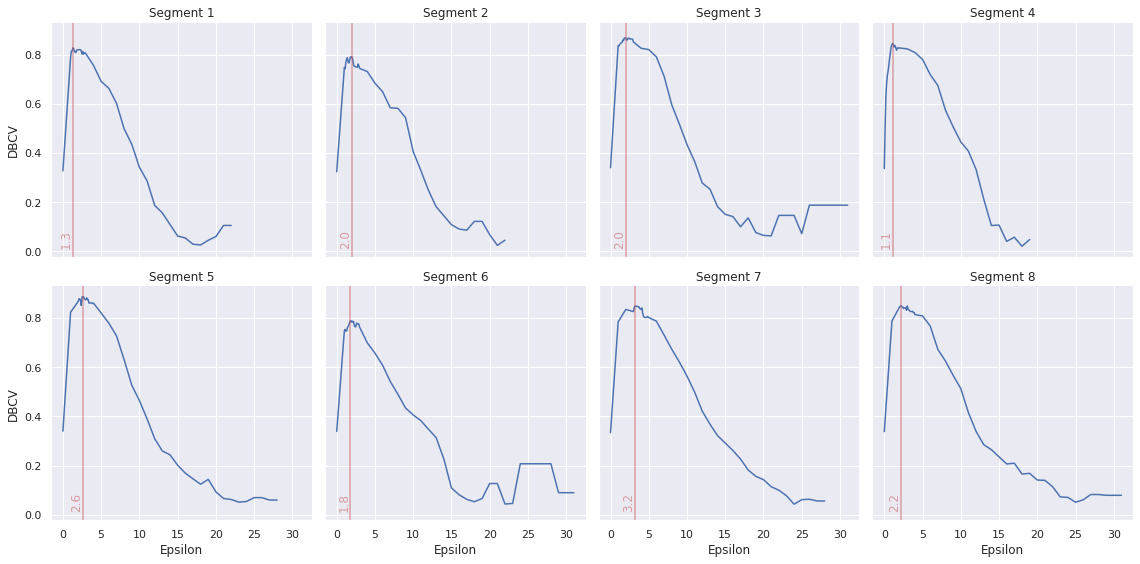

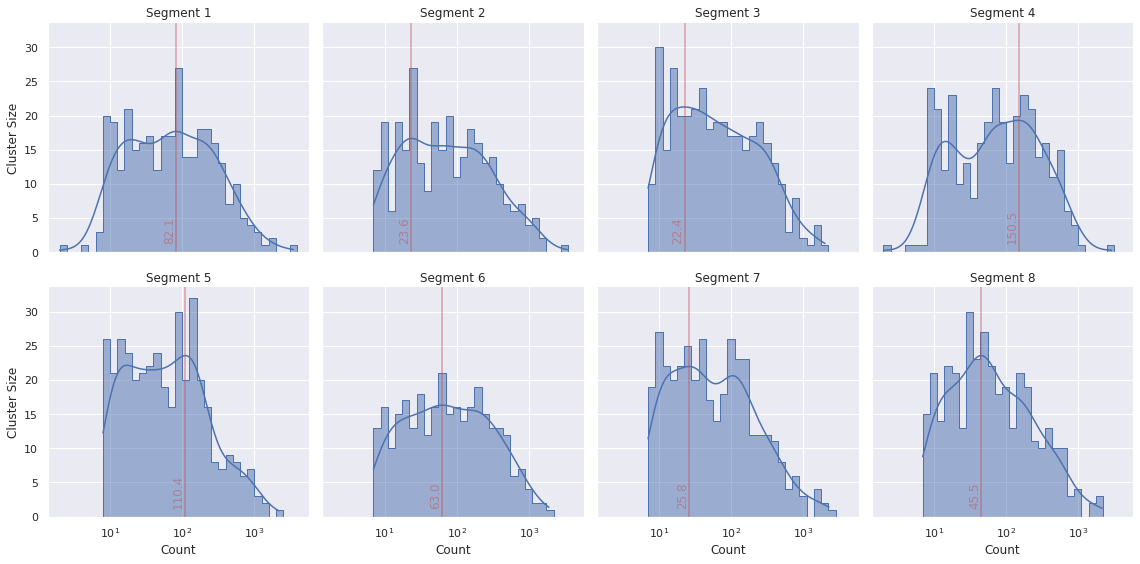

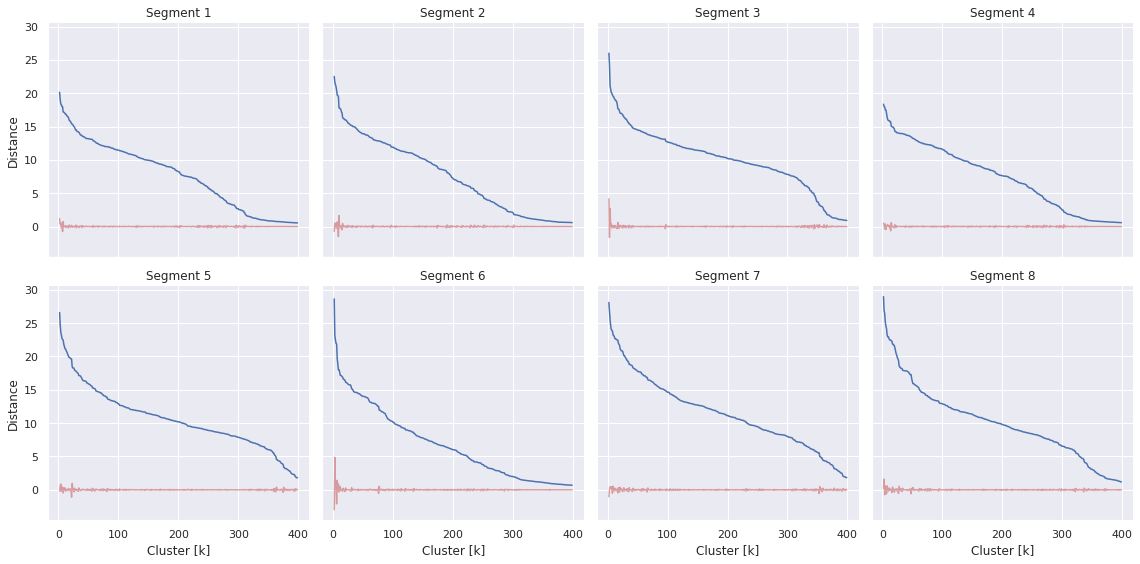

,n_cluster,unclustered,H_unmatch,N_unmatch,epsilon_best,dbcv_best
segment,,,,,,
1,323,0,137,146,1.3,0.826700
2,301,0,99,106,2.0,0.790150
3,365,0,113,113,2.0,0.867006
4,337,2,2,102,1.1,0.844672
5,387,0,121,128,2.6,0.885985
6,305,0,79,3,1.8,0.788851
7,376,0,104,111,3.2,0.848274
8,363,0,119,125,2.2,0.849024


,segment,cluster,H,N,strain
accession,,,,,
>CY021716,1,204,H1,N1,A/AA/Huston/1945
>CY020292,1,204,H1,N1,A/AA/Marton/1943
>CY083917,1,78,H1,N1,A/Aalborg/INS132/2009
>CY063613,1,78,H1,N1,A/Aalborg/INS133/2009
>CY073732,1,78,H1,N1,A/Aalborg/INS283/2009
...,...,...,...,...,...
>KM374046,8,55,H7,N9,A/Zhejiang/LS01/2014
>CY095725,8,204,H1,N1,A/Zhejiang/X1/2009
>CY095752,8,204,H1,N1,A/Zhejiang/X2/2009


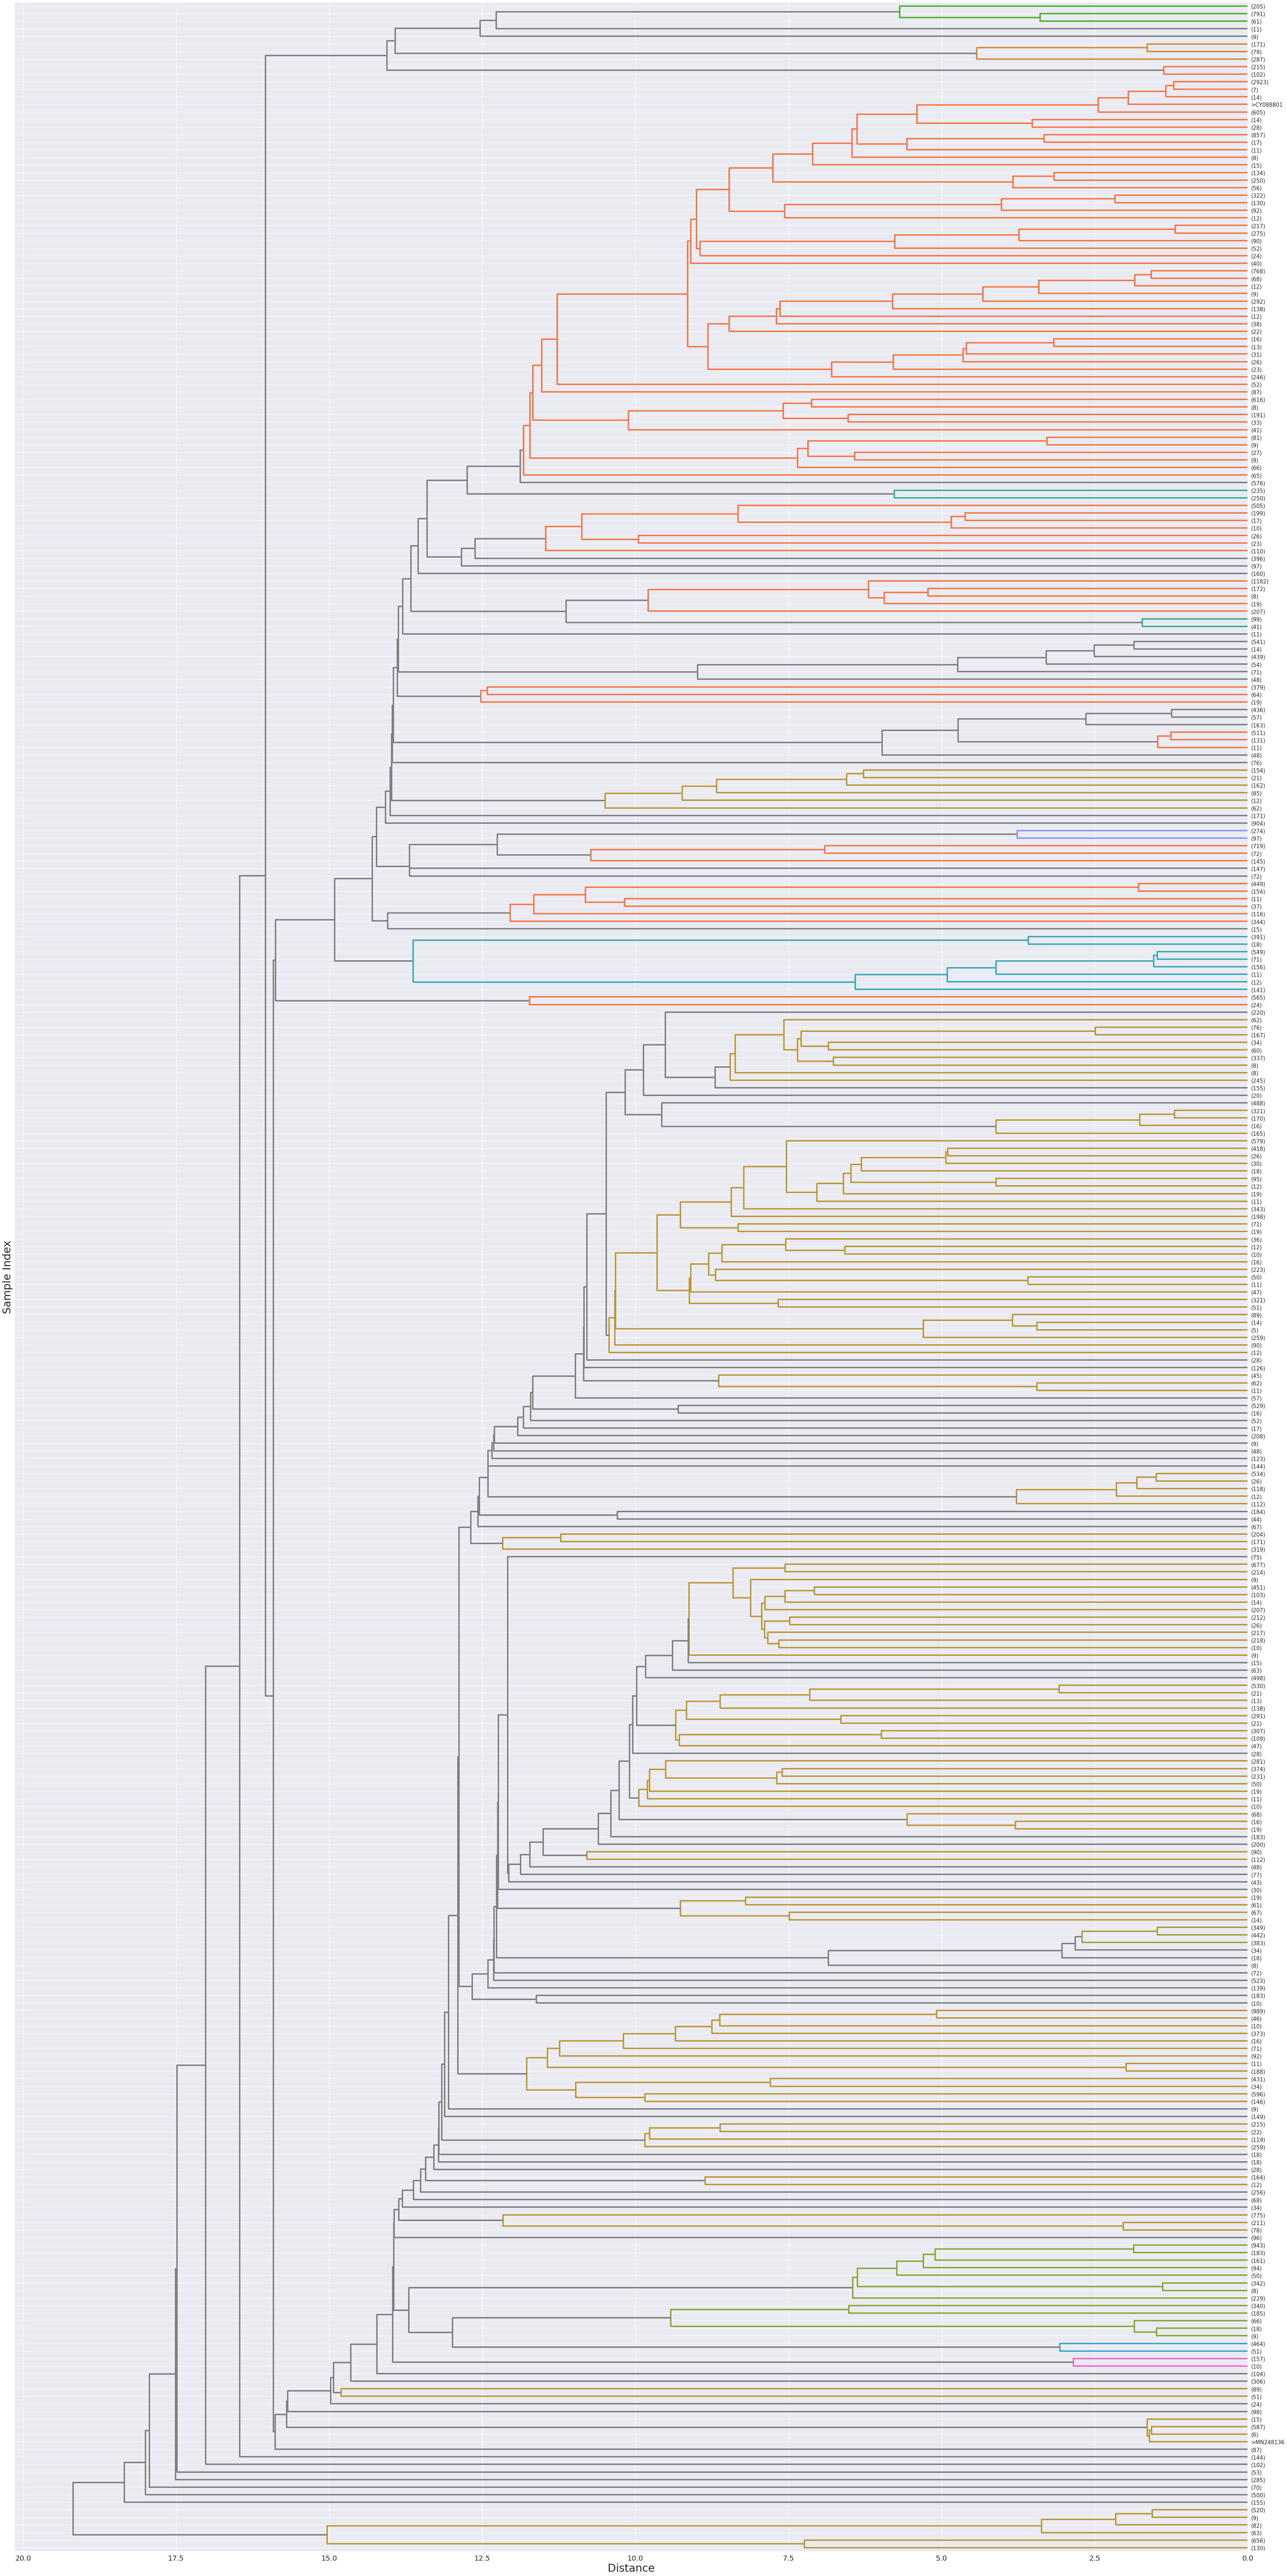

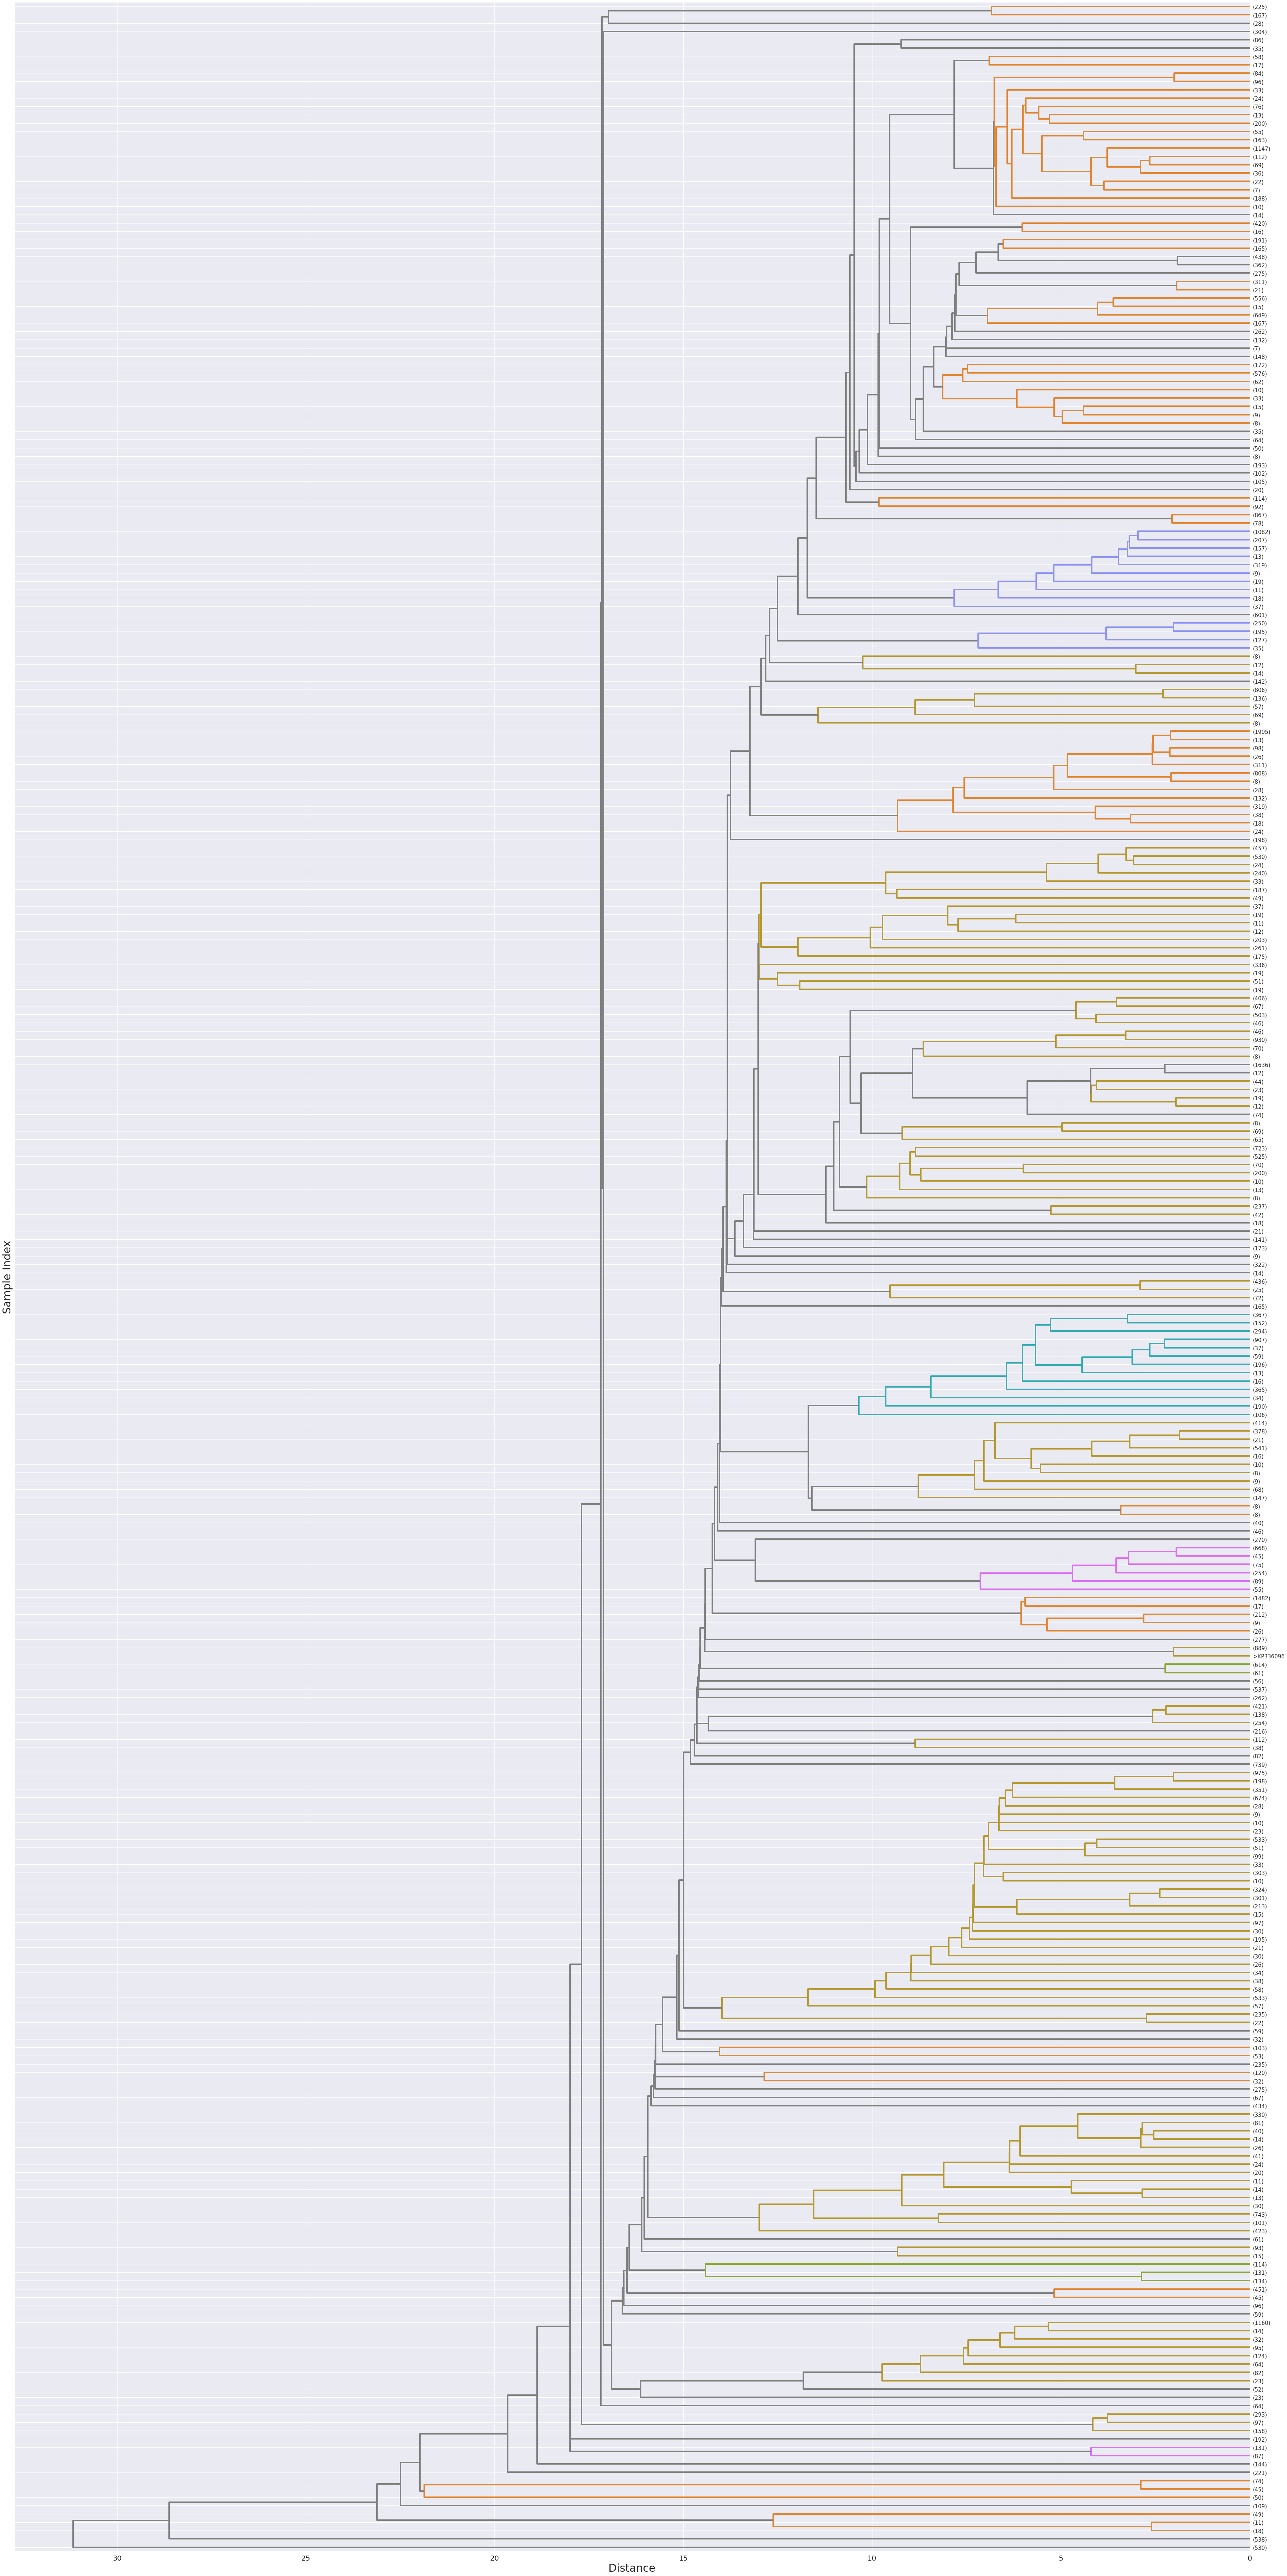

In [17]:
plot_dbcv(parameter)
plot_density(density)
plot_elbow(elbow)
display(information)
display(cluster)
plot_linkage(cluster, linkage, 4, 'H')
plot_linkage(cluster, linkage, 6, 'N')

### Interactions

#### Main Pipeline

- Visualize Nucleotide Sequences
    - taken from [here](https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/fasta-extension)
    - official jupyter extension example code
- Merge not working like expacted:
    - overlap = 4 (2x2)
        - like every possible combination
        - with 3 and 3 ist 9 not 6
        - which behaivior better?
    - Change:
        - Intersection and Combination
        - one column with intersection:
            - 3 and 3 = 3
        - one column with combination:
            - 3 and 3 = 9
    - Based on difficult merge and count combinations in pandas
    - third possible solutions reduce straon to one 
        - one column with same strain:
            - 1
            - maybe best

In [20]:
def plot_merge(merge):

    #better split in 4 figures
    #1 4 - 1 4
    #5 8 - 1 4
    #1 4 - 5 8
    #5 8 - 5 8
    
    sns.set()
    graph = sns.displot(data=merge, x="cluster_x", y="cluster_y", col ='segment_x', row = 'segment_y', binwidth=5, height=4)#, height=4
    graph.set_axis_labels("Cluster", "Cluster")
    graph.set_titles(col_template="Segment {col_name}", row_template="Segment {row_name}")
    #plt.subplots_adjust(top=0.9)
    #graph.fig.suptitle('Strain interactions of Segments Clusters')
    plt.tight_layout()
    plt.savefig('Interaction_Merge.svg')
    plt.savefig('Interaction_Merge.pdf')
    plt.show() 

In [99]:
def view_fasta(data):
    
    bundle = {}
    bundle['application/vnd.fasta.fasta'] = data
    bundle['text/plain'] = data
    display(bundle, raw=True)

In [100]:
def alignment(fasta, outfasta, outmsa, threads):    

    fasta.to_csv(outfasta, header=None, index=True, sep='\n', mode='w')

    mafft_cline = MafftCommandline(input=outfasta, thread=threads)
    stdout, stderr = mafft_cline()

    #os.remove('tmp.fasta') 
    with open(outmsa, "w") as handle:
        handle.write(stdout)
    
    return(stdout)

In [101]:
fasta = centroid.query('segment == 4 & centroid == True').merge(genome, on = 'accession')[['cluster', 'genome']].reset_index()

fasta['name'] = fasta.accession.astype(str).str.cat(fasta.cluster.astype(str), sep='|')

view_fasta(alignment(fasta[['name', 'genome']].set_index('name'), 'segment_4.fasta', 'segment_4.msa', 6))

>CY113957|325
----------------taattctattaaccat----------gaagactatcattgcttt
g---------agctacattttatgtctggttttcgctcaaaaacttcccggaaatga---
---------------------------caacagcacagcaacgctgtgcctgggacatca
tgcagtgccaaacggaacactagtgaaaacaatcacgaatgatcaaattgaagtgactaa
tgctactgagctggttcagagttcctcaacaggtagaatatgcgac---agtcctcaccg
aatccttgatggaaaaaactgcacactgatagatgctctattgggagaccctcattgtga
tggcttccaaaataagg---aatgggacctttttgttgaacgcagcaaagcttacagcaa
---ctgttacccttatgatgtgccggattatgcctcccttaggtcactagttg-------
--cctcgtcaggcaccctggagtttatcaatgaagacttcaattggactgga------gt
cgctca---ggatgggggaagctatgcttgcaaaag-------gggatctgttaacagtt
tctttagtagattgaattggttgcacaa---attagaatacaaa---------tatccag
cgctgaacgtgac-tatgccaaacaatggcaaatttgacaaattgtacatttggggggtt
caccacccgagcacggacagtgaccaaaccagcctatatgttcgagcatcagggagagtc
acagtctctaccaaaagaagccaacaaactgtaatcccgaatatcgggtctagaccctgg
gtaaggggtcagcccagtagaataagcatctattggacaatagtaaaaccgggagacata
cttttgattaatagcacagggaatctaattgctcctcggggttacttcaaaat-------
----------

In [21]:
try:

    interaction = pd.read_csv('interaction.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    merge = pd.read_csv('merge.csv', sep = ',', na_filter = False, header = 0)

except:

    occurence = cluster.reset_index(drop = True).drop(['H', 'N'], axis = 1).drop_duplicates()#[['segment', 'cluster', 'strain']]

    merge = (occurence.merge(occurence, on=['strain'], suffixes = ["_x", "_y"]))# & segment_x != segment_y')
    interaction = (occurence.query('segment == 1').drop(['segment'], axis = 1)
             .merge(occurence.query('segment == 2').drop(['segment'], axis = 1), on=['strain'], suffixes = ["_1", "_2"])
             .merge(occurence.query('segment == 3').drop(['segment'], axis = 1), on=['strain'])
             .merge(occurence.query('segment == 4').drop(['segment'], axis = 1), on=['strain'], suffixes = ["_3", "_4"])
             .merge(occurence.query('segment == 5').drop(['segment'], axis = 1), on=['strain'])
             .merge(occurence.query('segment == 6').drop(['segment'], axis = 1), on=['strain'], suffixes = ["_5", "_6"])
             .merge(occurence.query('segment == 7').drop(['segment'], axis = 1), on=['strain'])
             .merge(occurence.query('segment == 8').drop(['segment'], axis = 1), on=['strain'], suffixes = ["_7", "_8"])
             .groupby(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'])
             .count().reset_index().set_index('strain'))

    interaction.to_csv('interaction.csv', index=True, header=True, sep=',', mode='w')
    merge.to_csv('merge.csv', index=False, header=True, sep=',', mode='w')

    #interaction.to_latex('interaction.tex')
    #merge.to_latex('merge.tex')

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
strain,,,,,,,,
263,78,245,295,241,88,187,135,295
258,319,4,358,53,40,290,3,37
247,177,118,11,8,6,1,181,113
229,6,79,7,17,8,97,335,9
215,129,220,95,303,117,177,107,43
...,...,...,...,...,...,...,...,...
1,190,211,91,315,262,91,29,133
1,190,211,91,315,262,81,239,197
1,190,211,91,315,262,81,239,133


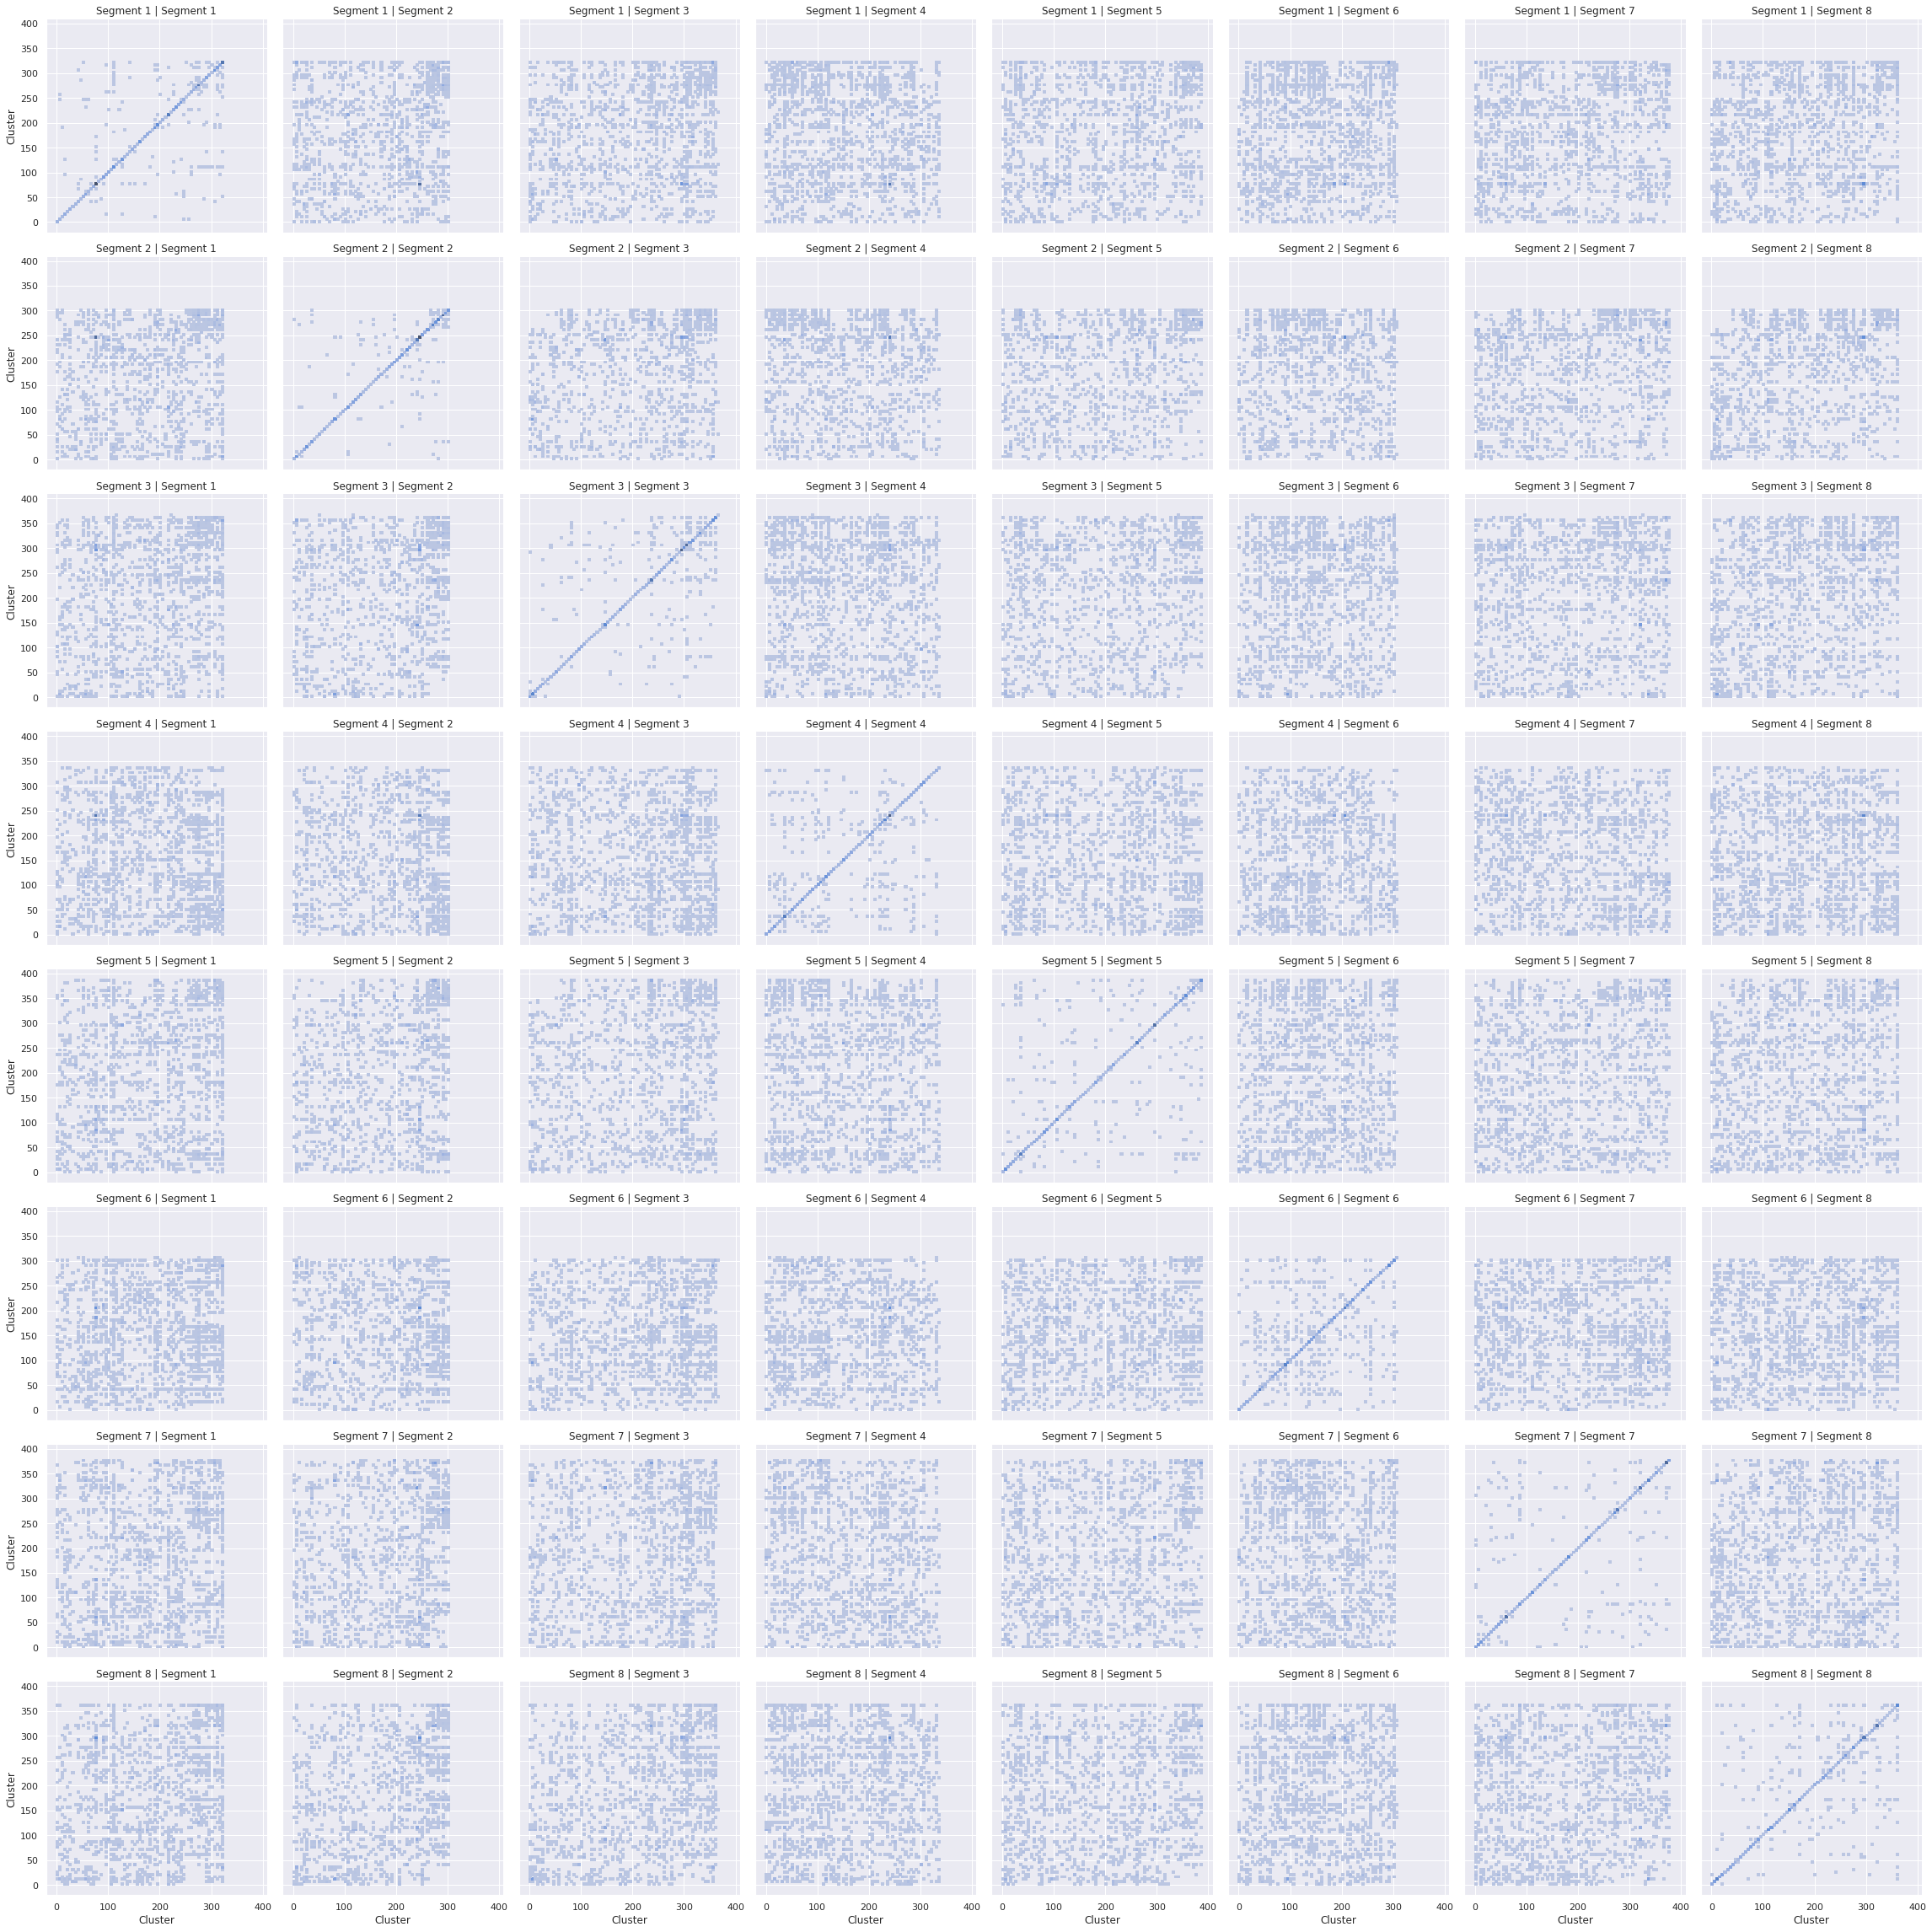

In [22]:
display(interaction.sort_index(ascending = False))
plot_merge(merge)

### Unused Functions

In [25]:
#def plot_interactions(dataframe, x, y):

#    subset = dataframe.query('segment_x == @x & segment_y == @y')
    
#    plot = (ggplot(subset, aes(x="cluster_x", y="cluster_y"))
#     + xlab("Cluster Segment " + str(x))
#     + ylab("Cluster Segment " + str(y))
#     + ggtitle("Segment Cluster Interactions")
#     + geom_bin2d(binwidth = 3)
#     + geom_density_2d(colour = "strain")       
#     + geom_tile(aes(fill = str(column), height = 3, width = 3))
#     + scale_fill_gradient(low="lightgray", high="blue")
#     + theme_538()
#    )
    
#    return(plot)

In [26]:
#occurence = cluster.groupby(['segment', 'cluster', 'strain']).size().to_frame(name='size').reset_index()
#merge = occurence.merge(occurence, on=['strain']).query('segment_x != segment_y')
#merge['intersection'] = merge.loc[:, ['size_x', 'size_y']].min(axis=1)
#merge['sum'] = merge.loc[:, ['size_x', 'size_y']].sum(axis=1)
#merge.query('segment_x == 1 & segment_y == 3', inplace=True)
#interaction = merge.groupby(['segment_x', 'segment_y', 'cluster_x', 'cluster_y']).sum().reset_index()#.set_index('combinations')

#occurence = cluster.reset_index(drop = True).drop(['H', 'N'], axis = 1).drop_duplicates()#[['segment', 'cluster', 'strain']]
#merge = occurence.merge(occurence, on=['strain']).query('segment_x != segment_y')
#interaction = merge.groupby(['segment_x', 'segment_y', 'cluster_x', 'cluster_y']).count().reset_index().set_index('strain')

In [27]:
#subset = merge.query('segment_x == 4 & segment_y == 7')
 
#(ggplot(subset, aes(x = "cluster_x", y = "cluster_y"))
# + xlab("Cluster Segment " + str(4))
# + ylab("Cluster Segment " + str(2))
# + ggtitle("Segment Cluster Interactions")
# + theme_538()
# + stat_density_2d(geom = "geom_density_2d")
# + geom_bin2d(binwidth = 1)
# + scale_x_continuous(limits = [-50, 300])
# + scale_y_continuous(limits = [-50, 300])
#)

In [28]:
#    plot = (ggplot(parameter, aes(x="epsilon", y='DBCV', colour = "factor(segment)")) 
#     + labs(
#        x="Epsilon",
#        y="DBCV",
#        colour="Segment",
#        title="DBCV by changing Epsilon",
#     )
#     + geom_line()
#    #+ geom_vline(aes(xintercept = epsilon_best))
#     + scale_x_continuous()
#     + scale_y_continuous()
#     + facet_wrap('~segment', ncol = 4)
#     + theme_538()
#    )
    
#    return(plot)

#    plot = (ggplot(density, aes(x="size", colour = "factor(segment)", fill = "factor(segment)")) 
#     + labs(
#        x="Cluster Size",
#        y="Density",
#        fill="Segment",
#        colour="Segment",
#        title="Cluster Size Distribution",
#     )
#     + geom_density(alpha = 0.25)
#     + scale_x_log10()
#     + scale_y_continuous()
#     + facet_wrap('~segment', ncol = 4)
#     + theme_538()
#    )
    
#    return(plot)